# Solve 1D advection diffusion problem

$$
\frac{\partial c}{\partial t} + w_s \frac{\partial c}{\partial z} - \frac{\partial}{\partial z}\left( F\right) =0
$$

where

$$
F=K_v \frac{\partial c}{\partial z}
$$

with boundary conditions

$$
F = f(t),\ z =0
$$

$$
F = 0,\ z=H
$$

In [1]:
# Gotta find my FFTW_PATH
!export FFTW_PATH=/path/to/your/fftw_prefix 

In [2]:
import time
import numpy as np
from scipy.interpolate import interp1d
import dedalus.public as de
from dedalus.tools  import post

from dedalus.extras.plot_tools import quad_mesh, pad_limits, plot_bot

import logging
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)


Bad key "backend.qt5" on line 8 in
/home/suntans/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
%matplotlib notebook

In [4]:
# Constants

H = 5. # Depth

nz = 64

K_0 = 1e-1 # Diffusivity - had to boost this to actually get the sediment into the water column
ws = 1e-3 # settling velocity

#E = -1e-3 # constant erosion rate [c/s]
#E = -1e-2 # constant erosion rate [c/s]

uniform_diffusion = True

In [38]:
# Load the current velocity timeseries
#U = np.load('KISSME2017_Event_5_SigU_5m.pkl', allow_pickle=True)
omega = 2*np.pi/10
ts = np.linspace(0, 20, 100)
U = np.sin(ts*omega)


# Interpolate onto model timestep
#ts_i = np.linspace(0, len(U), 1885)
#_int = np.interp(ts, U)
#U_int = np.abs(U_int)

#plt.figure()
#plt.plot(ts, U_int, label='U')

# Calculate erosion flux
d_sea = 1025  # density
Cd = 0.0025  # drag coefficient
tau_crit = 0.2 # critical shear

tau_bed = d_sea * Cd * U**2
E = 0.01 * ((tau_bed - tau_crit)/tau_crit)
ind = E < 0
E[ind] = 0

#plt.plot(ts, tau_bed, label='Bed stress')
#plt.plot(ts, E*10, label='E x 10')
#plt.legend()


In [39]:
# Try using interpolate object
E_int = interp1d(ts, E, kind='cubic')


<IPython.core.display.Javascript object>


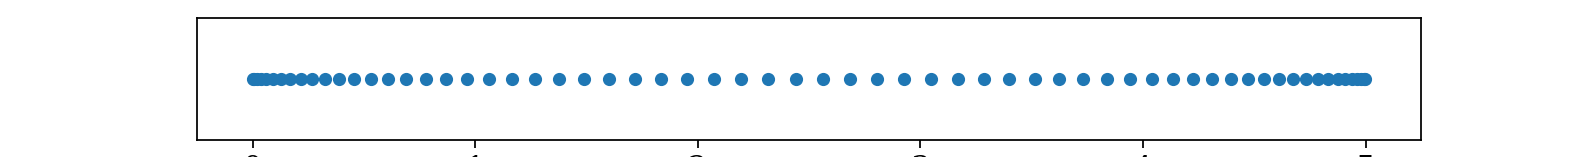

[]

In [40]:
# Create the domain

z = de.Chebyshev('z',nz,interval=[0.,H])
domain = de.Domain([z],grid_dtype='float')

grid_normal = z.grid(scale=1)

plt.figure(figsize=(10, 1))
plt.plot(grid_normal, np.zeros_like(grid_normal), 'o', markersize=5)
plt.gca().yaxis.set_ticks([])


In [41]:
def BoundaryForcing(*args):
    """This function applies its arguments and returns the forcing"""
    t = args[0].value # this is a scalar; we use .value to get its value
    return E_int(t)


def Forcing(*args, domain=domain, F=BoundaryForcing):
    """
    This function takes arguments *args, a function F, and a domain and
    returns a Dedalus GeneralFunction that can be applied.
    """
    return de.operators.GeneralFunction(domain, layout='g', func=F, args=args)

# Now we make it parseable, so the symbol BF can be used in equations
# and the parser will know what it is.
de.operators.parseables['BF'] = Forcing


In [61]:
# Create the problem
problem = de.IVP(domain, variables=['c','F'])
problem.parameters['ws'] = ws
#problem.parameters['E'] = E_int


#ncc = domain.new_field(name='E')
#ncc['g'] = E
#problem.paramters['E'] = ncc


if uniform_diffusion:
    problem.parameters['K'] = K_0
else:
    # Add vertically varying diffusion
    ncc = domain.new_field(name = 'K')
    ncc['g'] = (H-z)*K_0
    problem.parameters['K'] = ncc
    #plot_bot(ncc)
    

problem.add_equation('dt(c) + ws * dz(c) - dz(F) = 0')
problem.add_equation('F - K * dz(c) = 0')

# Add the time varying boundary conditions
problem.add_bc('left(F) = left(-BF(t))')
problem.add_bc('right(F) = 0')

In [62]:
solver = problem.build_solver(de.timesteppers.RK443)

solver.stop_sim_time = 6*np.pi
solver.stop_wall_time = 1000.
solver.stop_iteration = np.inf
dt = 0.01

# Store data for final plot
# Initial conditions
z = domain.grid(0)
c = solver.state['c']

c.set_scales(1, keep_data=True)
c_list = [np.copy(c['g'])]
t_list = [solver.sim_time]

start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 20== 0:
        logger.info("Time step {}".format(solver.iteration))
        c.set_scales(1, keep_data=True)
        c_list.append(np.copy(c['g']))
        t_list.append(solver.sim_time)
end_time = time.time()

# Print statistics
logger.info('Total time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)
logger.info('Average timestep: %f' %(solver.sim_time/solver.iteration))

2019-11-21 13:47:42,271 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s
2019-11-21 13:47:42,404 __main__ 0/1 INFO :: Time step 20
2019-11-21 13:47:42,551 __main__ 0/1 INFO :: Time step 40
2019-11-21 13:47:42,678 __main__ 0/1 INFO :: Time step 60
2019-11-21 13:47:42,764 __main__ 0/1 INFO :: Time step 80
2019-11-21 13:47:42,892 __main__ 0/1 INFO :: Time step 100
2019-11-21 13:47:43,016 __main__ 0/1 INFO :: Time step 120
2019-11-21 13:47:43,138 __main__ 0/1 INFO :: Time step 140
2019-11-21 13:47:43,297 __main__ 0/1 INFO :: Time step 160
2019-11-21 13:47:43,434 __main__ 0/1 INFO :: Time step 180
2019-11-21 13:47:43,577 __main__ 0/1 INFO :: Time step 200
2019-11-21 13:47:43,711 __main__ 0/1 INFO :: Time step 220
2019-11-21 13:47:43,867 __main__ 0/1 INFO :: Time step 240
2019-11-21 13:47:44,023 __main__ 0/1 INFO :: Time step 260
2019-11-21 13:47:44,137 __main__ 0/1 INFO :: Time step 280
2019-11-21 13:47:44,273 __main__ 0/1 INFO :: Time step 3

In [63]:
c_array = np.array(c_list)
t_array = np.array(t_list)
zmesh, tmesh = quad_mesh(x=z, y=t_array)

<IPython.core.display.Javascript object>


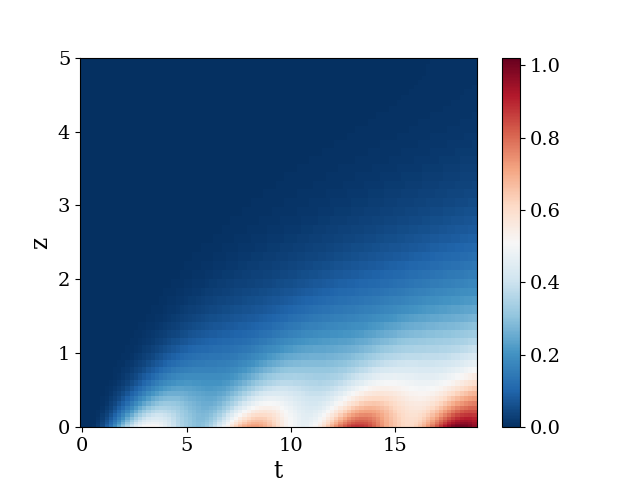

In [64]:
plt.figure()
plt.pcolormesh(tmesh.T, zmesh.T, c_array.T, cmap='RdBu_r')
plt.axis(pad_limits(tmesh, zmesh))
plt.colorbar()
plt.ylabel('z')
plt.xlabel('t')

plt.show()

In [65]:
c_array.shape, z.shape, len(t_list)

((95, 64), (64,), 95)

<IPython.core.display.Javascript object>


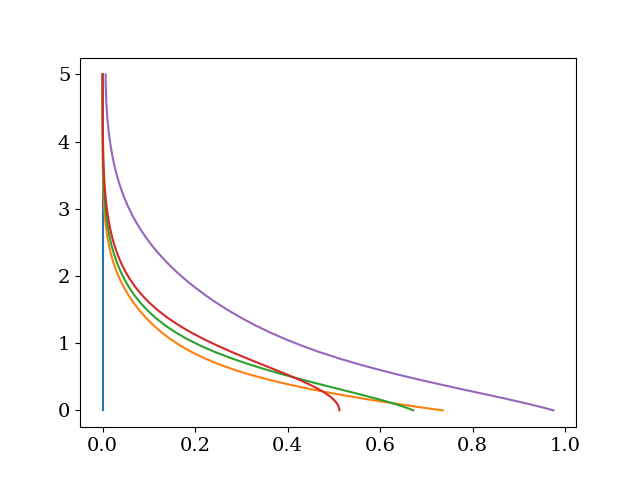

In [66]:
plt.figure()
plt.plot(c_array[0,:],z)
plt.plot(c_array[40,:],z)
plt.plot(c_array[45,:],z)
plt.plot(c_array[50,:],z)
plt.plot(c_array[-1,:],z)

<IPython.core.display.Javascript object>


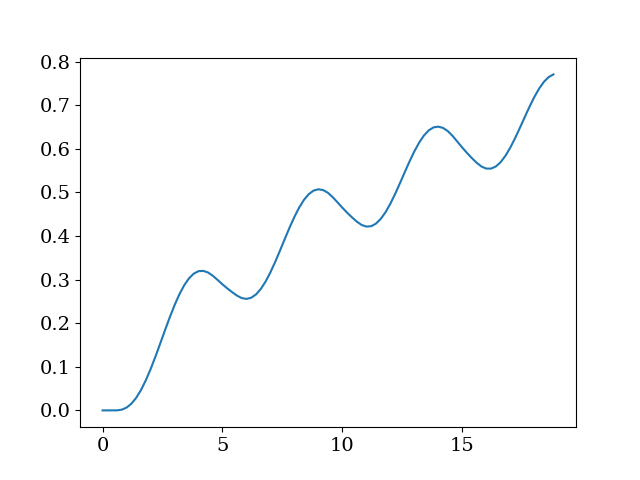

In [67]:
plt.figure()
plt.plot(t_list, c_array[:,10])